# Проект «Викишоп»

## Описание задачи

Магазину необходим инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Для этого предполагается использование модели машинного обучения

In [1]:
import sys
!{sys.executable} -m pip install spacy

!{sys.executable} -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk
import numpy as np
import spacy
import re
import tqdm

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from spacy.tokens import Doc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

## Подготовка

In [4]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

In [5]:
data.info()

display(data.head(15))

print(f"Количество дубликатов - {data.loc[data.duplicated(), 'text'].count()}")

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Количество дубликатов - 0


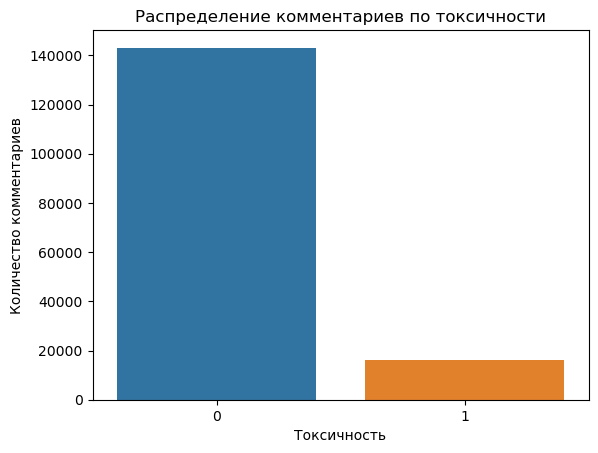

Количество токсичных комментариев - 16186, 
Количество нетоксичных комментариев - 143106


In [6]:
sns.countplot(
    data = data,
    x = data['toxic']
    )
plt.title('Распределение комментариев по токсичности')
plt.xlabel('Токсичность')
plt.ylabel('Количество комментариев')
plt.show()

print(f"Количество токсичных комментариев - {data.loc[data['toxic']  == 1, 'toxic'].count()}, \n"
     f"Количество нетоксичных комментариев - {len(data) - data.loc[data['toxic'] == 1, 'toxic'].count()}")

Налицо явный дисбаланс комментариев, поэтому при разделении данных. Данных с целевым признаком = 0 почти в 9 раз больше, чем с toxic = 1. Модели может не хватить токсичных комментариев для корректного их определения. Рациональным будет искусственное расширение тренировочной выборки токсичных комментариев. 

Перехожу к форматированию текста 

In [7]:
nlp = spacy.load("en_core_web_sm")

nltk.download('stopwords')

nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergejdvurecenskij/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sergejdvurecenskij/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def text_preprocessing(texts):
    re_text = re.compile('[^a-z A-Z]')
    stopwords_set = set(stopwords.words('english')) 
    preprocess_texts = []

    for text in tqdm.tqdm(texts):
        if isinstance(text, str):  # проверка, что text является строкой
            text = re_text.sub(' ', text)
            text = text.lower()
            w_tokens = word_tokenize(text)
            filtered = [w for w in w_tokens if w not in stopwords_set]
            preprocess_texts.append(' '.join(filtered))
        else:
            preprocess_texts.append('')  # добавляем пустую строку для нестроковых значений

    return preprocess_texts

In [9]:
data['preprocess_text'] = text_preprocessing(data['text'])

100%|█████████████████████████████████| 159292/159292 [00:16<00:00, 9397.64it/s]


In [10]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # отключаем компоненты, которые не нужны для лемматизации

In [11]:
def lemmatize_text(texts, batch_size=100):
    lemmatized_texts = []
    for doc in nlp.pipe(texts, batch_size=batch_size):
        lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))
    return lemmatized_texts

In [12]:
display(data['text'].iloc[0:10])
display(lemmatize_text(data['text'].iloc[0:10])) # проверка лемматизации

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: text, dtype: object

['Explanation \n why the edit make under my username Hardcore Metallica Fan be revert ? they be not vandalism , just closure on some gas after I vote at New York Dolls FAC . and please do not remove the template from the talk page since I be retire now.89.205.38.27',
 "D'aww ! he match this background colour I be seemingly stick with . thank .   ( talk ) 21:51 , January 11 , 2016 ( UTC )",
 'hey man , I be really not try to edit war . it be just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page . he seem to care more about the formatting than the actual info .',
 '" \n More \n I can not make any real suggestion on improvement - I wonder if the section statistic should be later on , or a subsection of " " type of accident " "   -I think the reference may need tidying so that they be all in the exact same format ie date format etc . I can do that later on , if no - one else do first - if you have any preference for format style on 

In [13]:
# Применяем функцию к датафрейму
data['lemmatized_text'] = lemmatize_text(data['preprocess_text'].tolist())

In [14]:
data.dropna(subset=['lemmatized_text'], inplace = True)

In [15]:
data.reset_index(drop = True, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             159292 non-null  object
 1   toxic            159292 non-null  int64 
 2   preprocess_text  159292 non-null  object
 3   lemmatized_text  159292 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.9+ MB


In [16]:
# проверка типов значений в lemmatized_text
values = []

for row in data['lemmatized_text']:
    values.append(type(row))
    
print(set(values))

{<class 'str'>}


### Вывод

В ходе предобработки данных были загружены датасеты в формат pandas DataFrame. Проверены дубликаты в данных. Проведена предобработка текста и его лемматизация. Также была проведена проверка форматов данных для корректной работы пайплайна. В процессе анализа данных было выявлено, что количество нетоксичных комментариев в 9 раз превосходит количество токсичных. Было принято решение размножить токсичные комментарии для более эффективного обучения модели.

## Обучение

In [17]:
RANDOM_STATE = 48

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data['lemmatized_text'],
    data['toxic'],
    random_state = RANDOM_STATE,
    test_size = 0.2,
    stratify = data['toxic']
    )

In [19]:
train_sample = pd.concat([X_train, y_train], axis = 1)
display(train_sample)
train_sample.info()

,lemmatized_text,toxic
91578,greg oliva mind business get start reference s...,0
64807,even right edit page delete statement show str...,0
103199,sure nominate article seem take time read entr...,0
119902,thank ever need common talk,0
80867,lie say,0
...,...,...
19911,ok sorry dunno britain english omg many fact t...,0
76096,grammy proof want,0
60049,oppose title article stay norton never emperor...,0
20055,bush jfk recent th anniversary upsurge kennedy...,0


<class 'pandas.core.frame.DataFrame'>
Index: 127433 entries, 91578 to 110932
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   lemmatized_text  127433 non-null  object
 1   toxic            127433 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


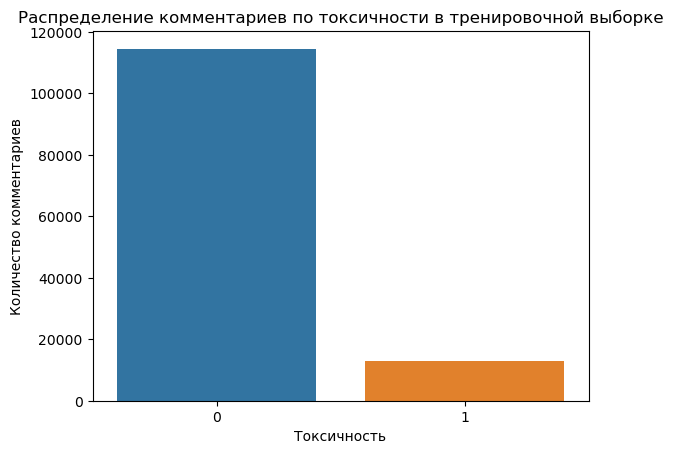

Количество токсичных комментариев - 12949, 
Количество нетоксичных комментариев - 114484


,lemmatized_text,toxic
111225,march utc remove two unbalanced tag kleck lott...,0
82148,prison time cbs television report early week f...,0
47963,regard flower seem establish azalea question i...,0
61962,joe hazelton,0
53779,rule I m eat someone parent,0
...,...,...
106336,already dreamguy lie write talk page notify ed...,0
123251,vandal sockpuppet temporarily block edit vanda...,0
30176,yeah actually seven year old black australian ...,0
32432,hi hi mom bra size,1


Размер выборки -  132433
Количество токсичных комментариев после семплирования - 17949, 
Количество нетоксичных комментариев - 114484


In [20]:
sns.countplot(
    data = train_sample,
    x = train_sample['toxic']
    )
plt.title('Распределение комментариев по токсичности в тренировочной выборке')
plt.xlabel('Токсичность')
plt.ylabel('Количество комментариев')
plt.show()

print(f"Количество токсичных комментариев - "
      f"{train_sample.loc[train_sample['toxic'] == 1, 'toxic'].count()}, \n"
      f"Количество нетоксичных комментариев - "
      f"{len(train_sample) - train_sample.loc[train_sample['toxic'] == 1, 'toxic'].count()}")


toxic_plus = train_sample.loc[train_sample['toxic'] == 1].sample(5000)
train_sample = pd.concat([train_sample, toxic_plus])
display(train_sample.sample(100))
print('Размер выборки - ', len(train_sample))

print(f"Количество токсичных комментариев после семплирования - " 
      f"{train_sample.loc[train_sample['toxic'] == 1, 'toxic'].count()}, \n"
      f"Количество нетоксичных комментариев - " 
      f"{len(train_sample) - train_sample.loc[train_sample['toxic'] == 1, 'toxic'].count()}")

In [21]:
X_train = train_sample['lemmatized_text']
y_train = train_sample['toxic']
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132433 entries, 91578 to 19266
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   lemmatized_text  132433 non-null  object
 1   toxic            132433 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ MB


In [22]:
# проверка размеров X_train, y_train
print(len(X_train), '- размер X_train,', len(y_train), '- размер y_train \n') 

# проверка наличия пустых значений
print(X_train.isna().sum(), 'пустых значений в X_train \n') 
print(y_train.isna().sum(), 'пустых значений в y_train \n')

# проверка пробелов в значениях toxic
print('Уникальные значения в y_train - ', y_train.unique(),'\n')

# проверка бесконечных значений
X_train = X_train.replace([np.inf, -np.inf], np.nan)
y_train = y_train.replace([np.inf, -np.inf], np.nan)
print(f'Количество бесконечных значений X_train - {X_train.isna().sum()}, y_train - {y_train.isna().sum()}\n')

# проверка размеров X_train и y_train
print(len(X_train), '- размер X_train,', len(y_train), '- размер y_train\n')
print(f'Форма X_train - {X_train.shape}, форма y_train - {y_train.shape}')

132433 - размер X_train, 132433 - размер y_train 

0 пустых значений в X_train 

0 пустых значений в y_train 

Уникальные значения в y_train -  [0 1] 

Количество бесконечных значений X_train - 0, y_train - 0

132433 - размер X_train, 132433 - размер y_train

Форма X_train - (132433,), форма y_train - (132433,)


In [23]:
pipeline = Pipeline(
    [
        (
            'vect', TfidfVectorizer()
        ),
        (
            'clf', LogisticRegression()
        )
])

In [24]:
param_grid = [
    {
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__ngram_range': [(1, 1), (1, 2)],
        'clf': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'clf__max_depth': (2, 3, 4),
        'clf__max_features': (2, 3, 4)
    },
    {
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__ngram_range': [(1, 1), (1, 2)],
        'clf': [LogisticRegression(random_state=RANDOM_STATE)],
        'clf__max_iter': [200, 300],
        'clf__C': [0.1, 1, 10]   
    }
]        

In [25]:
rand_search = RandomizedSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_iter=10,
    n_jobs=-1,
    random_state=RANDOM_STATE
    )

rand_search.fit(X_train, y_train)

# вывод результатов на экран
print(rand_search.best_estimator_, '- лучшая модель')
print(rand_search.best_score_, '- результат кросс-валидации на тренировочной выборке')

/Users/sergejdvurecenskij/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sergejdvurecenskij/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(C=10, max_iter=200, random_state=48))]) - лучшая модель
0.8851429495076305 - результат кросс-валидации на тренировочной выборке


/Users/sergejdvurecenskij/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
preds = rand_search.best_estimator_.predict(X_test)

f1_test = f1_score(y_test, preds)
print(f'Метрика f1 на тестовых данных для лучшей модели = {f1_test}')

Метрика f1 на тестовых данных для лучшей модели = 0.7800646368430006


### Вывод

Лучшей моделью по результатам кросс-валидации по метрике f1 была признана модель Линейной регрессии с гиперпараметрами C=10, max_iter=200. На тестовых данных выборка показала результат метрики f1 0.78

## Общий вывод

В ходе работ над проектом был проведен анализ исходных данных: датасета с комментариями и целевым признаком - токсичностью комментариев. 

В процессе подготовки данных была проведена предобработка и лемматизация text. 

В результате анализа данных в разбивке по целевому признаку было выявлено, что количество строк со значением признака toxic = 0 сильно превышает количество строк со значением toxic = 1. Было принято решение о сэпмлировании данных: добавлении в тренировочную выборки из еще 5000 строк со значением признака toxic = 1. 

В процессе работы над проектом был создан пайплайн с использованием tfdfvecotrizer и подбором гиперпараметров для линейной регрессии. Была проведена оценка по кросс-валидации, за скоринг взята метрика f1. 

Лучшей моделью по результатам кросс-валидации по метрике f1 была признана модель Линейной регрессии с гиперпараметрами C=10, max_iter=200. На тестовых данных выборка показала результат метрики f1 0.78